# CNN Cancer Detection Kaggle Mini-Project

## Imports and configs

In [19]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, ReLU
from keras import Input
from keras.optimizers import RMSprop, Adam
from keras.initializers import he_normal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.image as mpimg
import seaborn as sns

BASE_PATH = "data"
TRAIN_PATH = "train"
TEST_PATH = "test"

## Brief description of the problem and data

The goal of this project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The initial idea to approach this problem is to train a Convolutional Neural Network (CNN) with Keras to predict cancer based on the input images. The data is a slightly modified version of the PatchCamelyon benchmark dataset, which packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task.

### Train data

**220.025** images (tif extension) with dimensions **96 x 96** pixels with **3 color channels** (RGB) - identified by an **id** and labeled with **0 (not-cancerous)** or **1 (cancerous)**

In [20]:
df_raw = pd.read_csv(f"{BASE_PATH}/train_labels.csv", dtype=str)
df_raw["file_name"] = df_raw["id"].apply(lambda x: x + ".tif")
print("Images: ", df_raw.shape[0])
df_raw.head()

Images:  220025


,id,label,file_name
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


### Test data

**57.458** images (tif extension) with dimensions **96 x 96** pixels with **3 color channels** (RGB) - identified by an **id**

In [21]:
df_test = pd.DataFrame({"file_name": os.listdir(f"{BASE_PATH}/{TEST_PATH}")})
df_test['id'] = df_test.file_name.apply(lambda x: x.split(".")[0])
print("Images: ", df_test.shape[0])
df_test.head()

Images:  57458


,file_name,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif,fd0a060ef9c30c9a83f6b4bfb568db74b099154d
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif,1f9ee06f06d329eb7902a2e03ab3835dd0484581
2,19709bec800f372d0b1d085da6933dd3ef108846.tif,19709bec800f372d0b1d085da6933dd3ef108846
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif,7a34fc34523063f13f0617f7518a0330f6187bd3
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed


## Exploratory Data Analysis (EDA)

As the train data doesn't have missing values, the only cleaning procedure that I will apply is resampling the data in order to have the same amount of images for both labels (0 and 1). As the the label 0 has more images, I will downsample it to equalize them. Below I also show a sample of images from both labels to get a sense of their differences.

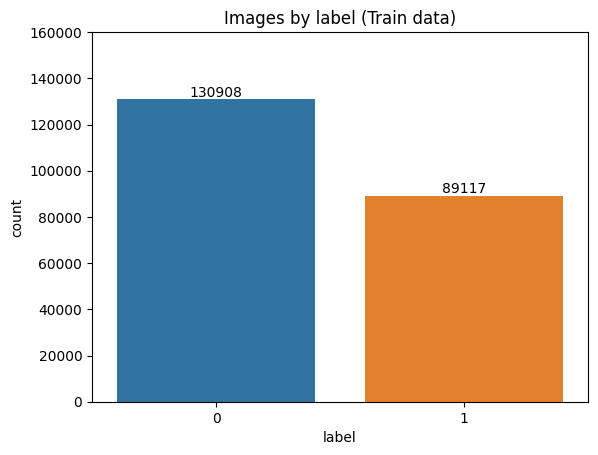

In [22]:
ax = sns.countplot(df_raw, x="label", hue="label")
ax.set_title("Images by label (Train data)")
plt.ylim(0, 160000)
for i in ax.containers:
    ax.bar_label(i)

In [23]:
def show_images(label):
    images = df_raw.query(f"label == '{label}'").sample(10).file_name.tolist()
    fig, ax = plt.subplots(2, 5, figsize=(12, 4))
    fig.suptitle(f"Sample of images with label {label}", fontsize=13, fontweight='bold')
    for i, axis in enumerate(ax.flat):
        file = str(f"{BASE_PATH}/{TRAIN_PATH}/{images[i]}")
        axis.imshow(mpimg.imread(file))

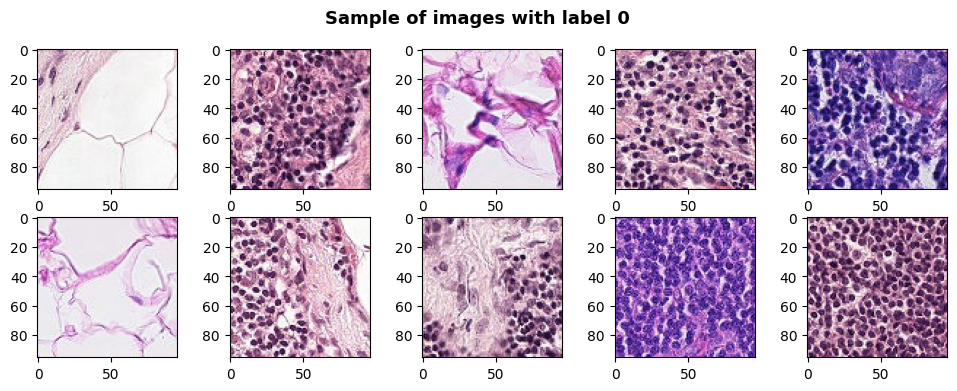

In [24]:
show_images(label = "0")

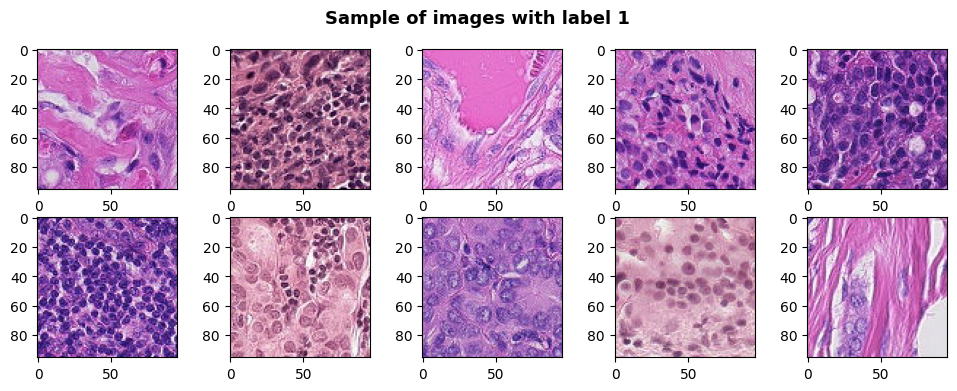

In [25]:
show_images(label = "1")

### Plan of approach to solve the problem

The plan is to train a Convolutional Neural Network (CNN) with Keras to predict cancer based on the input images. Initially I will resample the data keeping 89.000 images for each label (0 or 1). And then I will split the data in train and validation sets to use at training the model and evaluating the results. After that I will apply some techniques as data augmentation to improve the ability of the model to deal with different variations of the images that can happen when using the model to predict new cases. I also rescale the values on the images dividing by 255 to normalize them in order to improve the training process.

### Resampling and splitting train data

In [26]:
SAMPLE_SIZE = 89000

df = df_raw.groupby('label').sample(SAMPLE_SIZE)
df_train, df_val = train_test_split(df, test_size=0.1, stratify=df.label)

### Generating data for training and validation

In [27]:
IMAGE_SHAPE = (96, 96, 3)
BATCH_SIZE = 32

img_gen = ImageDataGenerator(
    rescale = 1.0 / 255,
    samplewise_center = True,
    samplewise_std_normalization = True,
    horizontal_flip = True,
    vertical_flip = True
)

img_flow_train = img_gen.flow_from_dataframe(
    dataframe = df_train,
    directory = f"{BASE_PATH}/{TRAIN_PATH}",
    x_col = "file_name",
    y_col = "label",
    has_ext = True,
    target_size = IMAGE_SHAPE[:2],
    batch_size = BATCH_SIZE,
    class_mode='binary'
)

img_flow_val = img_gen.flow_from_dataframe(
    dataframe = df_val,
    directory = f"{BASE_PATH}/{TRAIN_PATH}",
    x_col = "file_name",
    y_col = "label",
    has_ext = True,
    target_size = IMAGE_SHAPE[:2],
    batch_size = 1,
    class_mode='binary',
    shuffle = False
)

Found 160200 validated image filenames belonging to 2 classes.
Found 17800 validated image filenames belonging to 2 classes.


## Model Architecture

### Model 1

A very simple Neural Network architecture for a binary classification problem to have a baseline for further improvements.

In [28]:
model1 = Sequential()
model1.add(Input(shape=IMAGE_SHAPE))
model1.add(Flatten())

model1.add(Dense(64))

model1.add(Dense(1, activation="sigmoid"))
model1.compile(Adam(0.01), loss="binary_crossentropy", metrics=["accuracy"])

h1 = model1.fit(img_flow_train, epochs = 10, verbose = 1, validation_data = img_flow_val)

Epoch 1/10


/opt/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5007/5007 ━━━━━━━━━━━━━━━━━━━━ 139s 28ms/step - accuracy: 0.5510 - loss: 4.0346 - val_accuracy: 0.5787 - val_loss: 3.8994
Epoch 2/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 139s 28ms/step - accuracy: 0.5496 - loss: 5.0453 - val_accuracy: 0.5838 - val_loss: 5.0665
Epoch 3/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 138s 27ms/step - accuracy: 0.5705 - loss: 6.0347 - val_accuracy: 0.5698 - val_loss: 7.2479
Epoch 4/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 138s 27ms/step - accuracy: 0.5726 - loss: 6.7823 - val_accuracy: 0.5917 - val_loss: 8.6956
Epoch 5/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 139s 28ms/step - accuracy: 0.5812 - loss: 7.0581 - val_accuracy: 0.5712 - val_loss: 6.8600
Epoch 6/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - accuracy: 0.5844 - loss: 7.4597 - val_accuracy: 0.5821 - val_loss: 7.2813
Epoch 7/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 139s 28ms/step - accuracy: 0.5885 - loss: 7.6860 - val_accuracy: 0.5680 - val_loss: 8.0713
Epoch 8/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 139s 28ms/step - accuracy: 0.5914 - lo

In [41]:
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,769,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,308,805 (20.25 MB)

 Trainable params: 1,769,601 (6.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,539,204 (13.50 MB)

### Model 2

Model 1 added with a simple Convolutional Neural Network (CNN) architecture and with learning rate decay. The idea is to apply what is well known for this kind of problem (input -> Conv -> MaxPooling -> Dense -> output) before trying more complex parameters and structure.

In [31]:
KERNEL_SIZE = (3, 3)
FILTERS = 32

model2 = Sequential()
model2.add(Input(shape=IMAGE_SHAPE))

model2.add(Conv2D(FILTERS, KERNEL_SIZE))
model2.add(ReLU())

model2.add(MaxPooling2D())
model2.add(Flatten())

model2.add(Dense(64))

model2.add(Dense(1, activation="sigmoid"))
model2.compile(Adam(0.01), loss="binary_crossentropy", metrics=["accuracy"])

lr_decay = ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.5, patience = 1, min_lr = 1e-5)

h2 = model2.fit(img_flow_train, epochs = 10, verbose = 1, validation_data = img_flow_val, callbacks = [lr_decay])

Epoch 1/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 204s 40ms/step - accuracy: 0.6689 - loss: 3.6713 - val_accuracy: 0.6924 - val_loss: 0.6282 - learning_rate: 0.0100
Epoch 2/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 203s 40ms/step - accuracy: 0.6894 - loss: 0.6372 - val_accuracy: 0.6124 - val_loss: 0.9912 - learning_rate: 0.0100
Epoch 3/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 206s 41ms/step - accuracy: 0.5463 - loss: 0.7120 - val_accuracy: 0.5639 - val_loss: 0.6960 - learning_rate: 0.0050
Epoch 4/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 206s 41ms/step - accuracy: 0.5843 - loss: 0.6672 - val_accuracy: 0.7194 - val_loss: 0.5660 - learning_rate: 0.0025
Epoch 5/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 204s 41ms/step - accuracy: 0.6942 - loss: 0.5839 - val_accuracy: 0.7065 - val_loss: 0.5862 - learning_rate: 0.0025
Epoch 6/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 203s 41ms/step - accuracy: 0.7141 - loss: 0.5564 - val_accuracy: 0.7234 - val_loss: 0.5410 - learning_rate: 0.0012
Epoch 7/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 205s 41ms/step -

In [42]:
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     4,524,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,575,173 (51.79 MB)

 Trainable params: 4,525,057 (17.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,050,116 (34.52 MB)

### Model 3

Model 2 with improved structure and parameters. The idea is to add more layers of convolution (input -> Conv -> MaxPooling -> Conv -> MaxPooling -> Conv -> MaxPooling -> Dense -> output), batch normalization, dropouts and improve some parameters.

In [33]:
FILTERS = (32, 64, 128)
DROPOUT = 0.2

model3 = Sequential()
model3.add(Input(shape=IMAGE_SHAPE))

model3.add(Conv2D(FILTERS[0], KERNEL_SIZE))
model3.add(ReLU())
model3.add(MaxPooling2D())
model3.add(Dropout(DROPOUT))

model3.add(Conv2D(FILTERS[1], KERNEL_SIZE))
model3.add(ReLU())
model3.add(MaxPooling2D())
model3.add(Dropout(DROPOUT))

model3.add(Conv2D(FILTERS[2], KERNEL_SIZE))
model3.add(ReLU())
model3.add(MaxPooling2D())
model3.add(Dropout(DROPOUT))

model3.add(Flatten())
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(ReLU())
model3.add(Dropout(DROPOUT))

model3.add(Dense(1, activation="sigmoid"))
model3.compile(Adam(0.01), loss="binary_crossentropy", metrics=["accuracy"])

lr_decay = ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.5, patience = 1, min_lr = 1e-5)

h3 = model3.fit(img_flow_train, epochs = 10, verbose = 1, validation_data = img_flow_val, callbacks = [lr_decay])

Epoch 1/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 265s 53ms/step - accuracy: 0.7756 - loss: 0.4883 - val_accuracy: 0.8433 - val_loss: 0.3584 - learning_rate: 0.0100
Epoch 2/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 263s 52ms/step - accuracy: 0.8397 - loss: 0.3689 - val_accuracy: 0.7395 - val_loss: 0.5289 - learning_rate: 0.0100
Epoch 3/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 264s 53ms/step - accuracy: 0.8792 - loss: 0.2911 - val_accuracy: 0.8920 - val_loss: 0.2591 - learning_rate: 0.0050
Epoch 4/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 265s 53ms/step - accuracy: 0.8904 - loss: 0.2700 - val_accuracy: 0.8057 - val_loss: 0.4295 - learning_rate: 0.0050
Epoch 5/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 265s 53ms/step - accuracy: 0.8984 - loss: 0.2489 - val_accuracy: 0.8935 - val_loss: 0.2561 - learning_rate: 0.0025
Epoch 6/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 263s 53ms/step - accuracy: 0.9036 - loss: 0.2404 - val_accuracy: 0.8756 - val_loss: 0.2859 - learning_rate: 0.0025
Epoch 7/10
5007/5007 ━━━━━━━━━━━━━━━━━━━━ 265s 53ms/step -

In [43]:
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,113,733 (38.58 MB)

 Trainable params: 3,371,073 (12.86 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 6,742,148 (25.72 MB)

## Results and Analysis

The first problem I faced was trying to train the models using only my local CPU. It was taking a long time even for a sample of the data. Then I removed the Tensorflow and Keras packages I was using and installed the ones that enable using the GPU of my computer. The amount of time to train decreased more than 5 times even using my simple local Mac.

About training the models, I chose an approach of starting with a very simple baseline model without using any convolutional layer to get a sense of the accuracy the model could reach. Then I created a new model with one convolutional and one max pooling layer and the accuracy gain was considerable, showing that this type of architecture was promising. Therefore in a third model I increased a bit more the amount of convolutional layers with more filters. Also, I added dropouts to avoid overfitting.

Below there are some plots with the training history of the models with the metrics for both train and validation data:

In [37]:
def show_model_history(h, model):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f"Model {model} training history", fontsize=13, fontweight='bold')
    axs[0].plot(h.history['accuracy'], label='train')
    axs[0].plot(h.history['val_accuracy'], label='validation')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')
    axs[1].plot(h.history['loss'], label='train')
    axs[1].plot(h.history['val_loss'], label='validation')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper left')

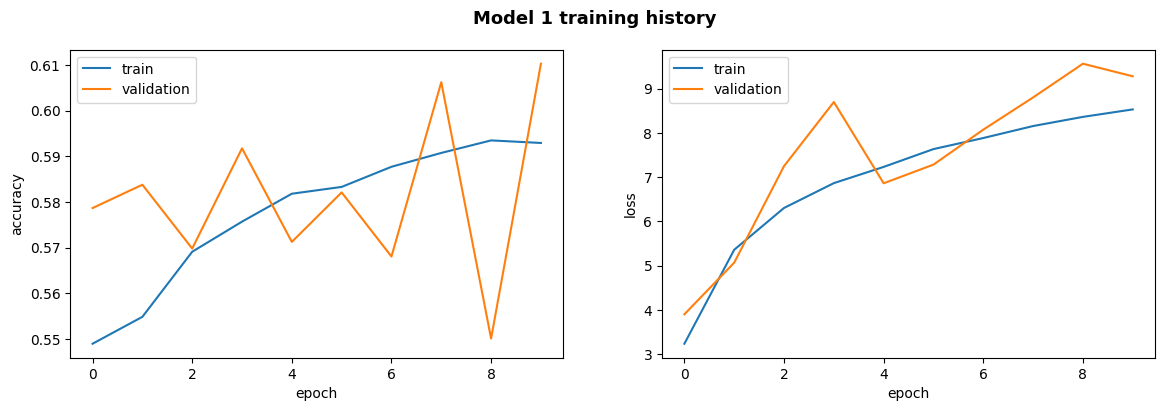

In [38]:
show_model_history(h1, "1")

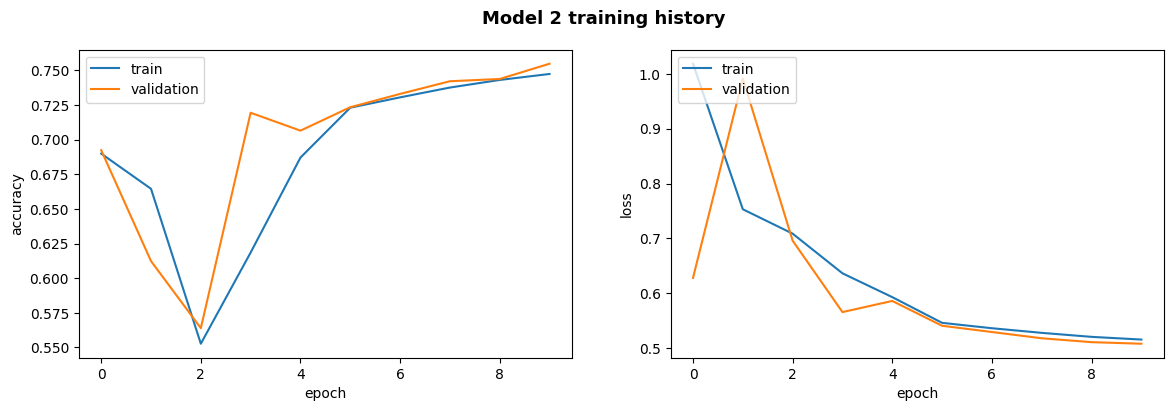

In [39]:
show_model_history(h2, "2")

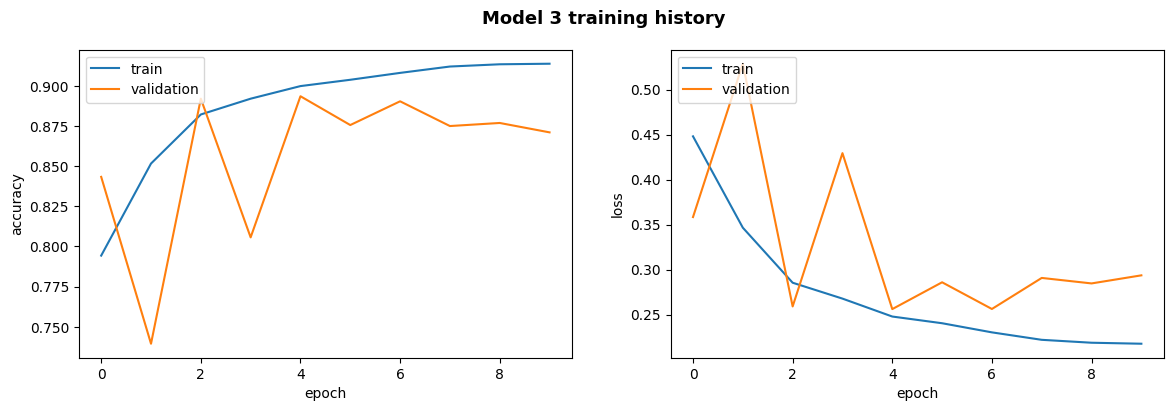

In [40]:
show_model_history(h3, "3")

### Validation data results of the best model

17800/17800 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step


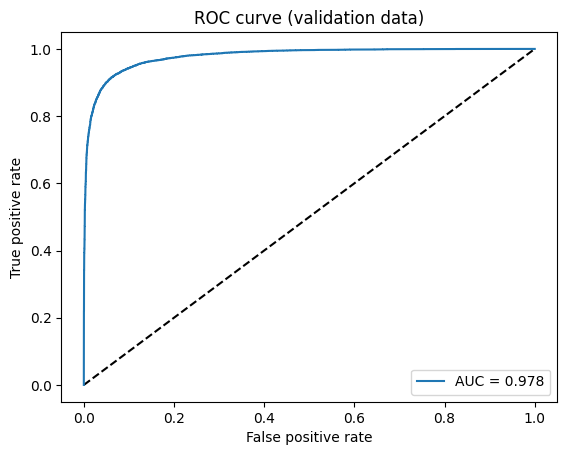

In [35]:
y_pred = model3.predict(img_flow_val)
y_true = img_flow_val.classes

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve (validation data)")
plt.legend(loc="best")
plt.show()

### Test data predictions with the best model

In [36]:
img_flow_test = img_gen.flow_from_dataframe(
    dataframe = df_test,
    directory = f"{BASE_PATH}/{TEST_PATH}",
    x_col = "file_name",
    has_ext = True,
    class_mode=None,
    target_size = IMAGE_SHAPE[:2],
    batch_size = 1,
    shuffle = False
)

df_test['label'] = (model3.predict(img_flow_test) > 0.5).astype("int32")
submission = df_test[['id','label']]
print(submission.head(10))
submission.to_csv("submission.csv", index = False)

Found 57458 validated image filenames.
   72/57458 ━━━━━━━━━━━━━━━━━━━━ 1:21 1ms/step  

/opt/miniconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 81s 1ms/step
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      0
2  19709bec800f372d0b1d085da6933dd3ef108846      0
3  7a34fc34523063f13f0617f7518a0330f6187bd3      0
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0
5  761dde7de22cb39a0dd67ce472163d66e5ac1568      0
6  58055ce8819717a100b48d019e139be4fdf997c0      0
7  9735b584631f4b942b022d40aecdbe2aa8f6ae5e      0
8  860bbd33f8483a45858c4998021bc7434117deda      0
9  99050fbce64ae16e48e8a3b09d38f3b16df63fbe      1


## Conclusion

After exploring different Convolutional Neural Network architectures, it's very clear for me that this approach is very powerful for image problems. Increasing the amount of convolutional and max pooling layers has a considerable effect on the metrics for train and validation data. However when using the model to predict for the test data (Kaggle submission), the AUC was lower than expected. So one of the lessons learned and also something to do as next steps on this work would be applying more regularization, dropouts, etc to reduce overfitting on the dataset not seen by the model.